# DEA WOfS and Water Classifier Notebook 

**Description:** This notebook allows users to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOfS) algorithm. 

The outputs of the WOfS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.

__Before you run this notebook:__ This notebook uses the dea module. You need to run "module load dea" in a terminal window and then launch jupyter notebooks in the same window so that your notebook can 'see' the dea module.

This notebook is based on a CEOS [notebook](https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb) 

The water classifier is based on [Mueller, et al. (2015)](## References) [github link to water classifier code](https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py)

__Date:__ May 2018

__Authors:__ Erin Telfer, Bex Dunn


## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [3]:
%pylab notebook

#import ipywidgets as widgets
import gc
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
import xarray as xr

#modules for datacube
import datacube
from datacube.storage import masking

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-WOfS and water classifier')

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

Populating the interactive namespace from numpy and matplotlib


## Define functions

In [4]:
def water_classifier(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Water classifier. Regression analysis based on Australia training data.
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified
        
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    dtype = blue.values.dtype 
    shape = blue.values.shape

    no_data =-9999

    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean=classified.astype('float64')
    
    y = dataset_in.y
    x = dataset_in.x

    time = None
    coords = None
    dims = None

    time = dataset_in.time
    coords = [time, y, x]
    dims = ['time', 'y', 'x']

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    dataset_out = xr.Dataset(
            {
                'wofs': data_array
            }, coords={'time': time,
                       'y': y,
                       'x': x})
    return dataset_out

In [5]:
# def LoadAreaofInterest(sensors, bands_of_interest, query, cloud_free_threshold):
#     """
#     Description:
#     Load data from datacube for multiple sensors
#     -----
#     Output:
#       dataset_out (xarray.DataSet) - dataset containing landsat band information for specified sensors
#     """

#     for sensor in sensors: #loop through specified
#         sensor_nbar = dc.load(product= sensor,
#                                measurements = bands_of_interest,group_by='solar_day', 
#                                **query) #load nbar
#         #retrieve the projection information before masking/sorting
#         crs = sensor_nbar.crs
#         crswkt = sensor_nbar.crs.wkt
#         affine = sensor_nbar.affine
#         #assign pq data variable
#         sensor_pq= sensor_nbar.pixel_qa
#         #create and use quality and cloud masks
#         mask_components = {'cloud_shadow': 'no_cloud_shadow',
#                    'cloud': 'no_cloud',}
#         quality_mask = masking.make_mask(sensor_pq, **mask_components)
#         good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
#         sensor_nbar2 = sensor_nbar.where(good_data)
#         del (sensor_nbar)

#         #calculate the percentage cloud free for each scene
#         cloud_free = masking.make_mask(sensor_pq,
#                                        cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
#         mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
#         del(cloud_free)
#         #discard data that does not meet the cloud_free_threshold
#         mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
#                                                                    how='all')
#         del(sensor_nbar2)
#         #assign masked data to array
#         sensor_clean[sensor] = mostly_good

#         print('loaded %s' % sensor) 
#     print('ls load complete')
    
#     nbar_clean = xr.concat(sensor_clean.values(), 'time')
#     nbar_clean = nbar_clean.sortby('time')
#     nbar_clean.attrs['crs'] = crs
#     nbar_clean.attrs['affin|e'] = affine
#     return nbar_clean

# Query and extract data from DEA

In [6]:
#User input: define details below

#Use this to manually define an upper left/lower right coords
lat_max = -12.4 #
lat_min = -12.7
lon_max = 135.2
lon_min = 134.9 

#define temporal range
start_of_epoch = '2016-01-01'
end_of_epoch =  '2017-01-01'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1',
                     'swir2',
                     ]

#set cloud free threshold
cloud_free_threshold = 0.10

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [7]:
#Query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print (query)

{'time': ('2016-01-01', '2017-01-01'), 'x': (134.9, 135.2), 'y': (-12.4, -12.7), 'crs': 'EPSG:4326'}


In [8]:
nbart = DEADataHandling.load_clearlandsat(dc, query, masked_prop=0.9)

Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ


Failed to resolve driver datacube.plugins.io.read::s3aio
Failed to resolve driver datacube.plugins.io.read::s3aio_test


    Loading 2 filtered ls7 timesteps
Loading ls8 PQ
    Loading 9 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


In [ ]:
# #Unhash and set dates if a subset of dates is required
# nbar_clean_subset = nbar_clean.sel(time=slice('2014-01-01','2015-01-01'))

# Classify water and calculate Water Observations from Space (WOfS)

## Use water classifier function

In [32]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier(nbart)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(water_class)

<xarray.Dataset>
Dimensions:  (time: 11, x: 1358, y: 1337)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T01:04:21 2016-05-24T01:03:52 ...
  * y        (y) float64 -1.311e+06 -1.311e+06 -1.311e+06 -1.311e+06 ...
  * x        (x) float64 3.203e+05 3.203e+05 3.204e+05 3.204e+05 3.204e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


## Calculate and plot WOfS

In [33]:
#note, this is using only one band for the count, and this isn't robust.

total_water_obs = water_class.wofs.sum(dim='time')
nbar_count = nbart.blue.count(dim='time')
wofs = ((total_water_obs/nbar_count)*100)

In [34]:
#Set up colour ramp details to meet DEA specified colour details
# wofs_cmap = mpl.colors.ListedColormap(['#000000', '#8e0101', '#cf2200', '#e38400',
#                                        '#e3df00', '#a6e300', '#62e300', '#00e32d',
#                                        '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
#                                        '#005fe3', '#000fe3', '#5700e3'])
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                       '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

In [35]:
wofs

<xarray.DataArray (y: 1337, x: 1358)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 9.090909, 9.090909, 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])
Coordinates:
  * y        (y) float64 -1.311e+06 -1.311e+06 -1.311e+06 -1.311e+06 ...
  * x        (x) float64 3.203e+05 3.203e+05 3.204e+05 3.204e+05 3.204e+05 ...

<IPython.core.display.Javascript object>


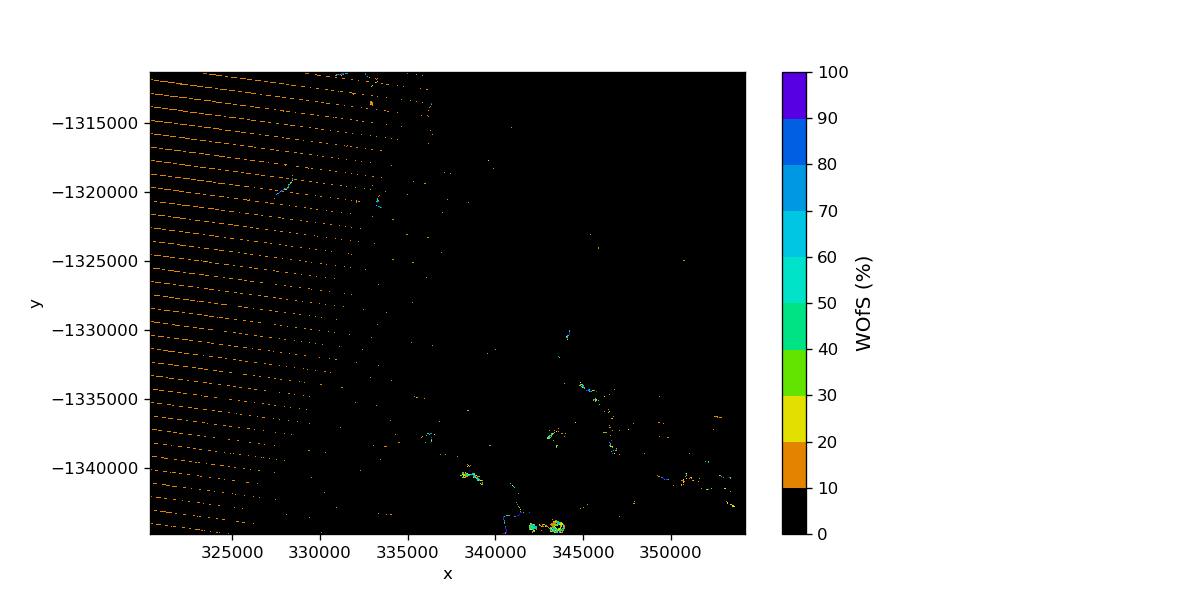

In [36]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='WOfS (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image

## References

1. Mueller, et al. 2015., *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. <https://doi.org/10.1016/j.rse.2015.11.003>
